<a href="https://colab.research.google.com/github/suriya-mouli/Alzheimer-s_Disease_Prediction/blob/main/Alzheimer's_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# STEP 0: INSTALL splitfolders
!pip install split-folders

In [3]:
# STEP 1: IMPORT ALL REQUIRED LIBRARIES

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, log_loss
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import splitfolders

# DATA LOADING





In [4]:
# STEP 2: LOAD DATA

dataset_dir = '/content/drive/MyDrive/augmented__ADNI'  # your augmented dataset path
classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
output_dir = '/content/drive/MyDrive/split_ADNI'

splitfolders.ratio(dataset_dir, output=output_dir, seed=42, ratio=(0.7, 0.15, 0.15))
# Now you have train, val, test folders in /split_ADNI

train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
test_dir = os.path.join(output_dir, 'test')

Copying files: 14000 files [04:24, 52.89 files/s]


In [5]:
# STEP 3: DATA GENERATORS
IMG_SIZE = (299, 299)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False
)

print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Testing samples: {test_gen.samples}")


Found 9800 images belonging to 4 classes.
Found 2100 images belonging to 4 classes.
Found 2100 images belonging to 4 classes.
Training samples: 9800
Validation samples: 2100
Testing samples: 2100


In [6]:
# STEP 4: BUILD XCEPTION MODEL

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299,299,3))
for layer in base_model.layers:
    layer.trainable = False  # freeze convolutional layers for feature extraction

x = base_model.output                       # extracted features
x = GlobalAveragePooling2D()(x)            # flatten feature maps
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 149, 149,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 149, 149,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 149, 149,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 147, 147,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 147, 147,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 147, 147,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 147, 147,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 147, 147,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 147, 147,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 147, 147,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 147, 147,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 74, 74,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 74, 74,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 74, 74,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 74, 74,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 74, 74,    │          0 │ add[0][0]       

 Total params: 21,387,052 (81.59 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [8]:
# STEP 5: TRAIN MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 194s 503ms/step - accuracy: 0.3660 - loss: 1.2887 - val_accuracy: 0.5676 - val_loss: 0.9961
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 97s 315ms/step - accuracy: 0.5351 - loss: 1.0311 - val_accuracy: 0.6095 - val_loss: 0.9003
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 97s 316ms/step - accuracy: 0.5763 - loss: 0.9510 - val_accuracy: 0.6386 - val_loss: 0.8416
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 97s 314ms/step - accuracy: 0.6052 - loss: 0.8999 - val_accuracy: 0.6619 - val_loss: 0.7973
Epoch 5/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 97s 315ms/step - accuracy: 0.6157 - loss: 0.8740 - val_accuracy: 0.6671 - val_loss: 0.7764
Epoch 6/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 97s 316ms/step - accuracy: 0.6317 - loss: 0.8415 - val_accuracy: 0.6767 - val_loss: 0.7498
Epoch 7/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 97s 316ms/step - accuracy: 0.6406 - loss: 0.8243 - val_accuracy: 0.6776 - val_loss: 0.7414
Epoch 8/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 97s 315ms/step - accuracy: 0.6408 - loss: 

In [9]:
# STEP 6: EVALUATE MODEL

test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

66/66 ━━━━━━━━━━━━━━━━━━━━ 17s 262ms/step - accuracy: 0.7481 - loss: 0.6113

Test Accuracy: 0.7414
Test Loss: 0.6105


In [10]:
# Predictions

y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 429ms/step


In [11]:
# Classification report

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
                  precision    recall  f1-score   support

    MildDemented       0.71      0.71      0.71       525
ModerateDemented       0.89      0.98      0.94       525
     NonDemented       0.72      0.75      0.74       525
VeryMildDemented       0.61      0.52      0.56       525

        accuracy                           0.74      2100
       macro avg       0.73      0.74      0.74      2100
    weighted avg       0.73      0.74      0.74      2100



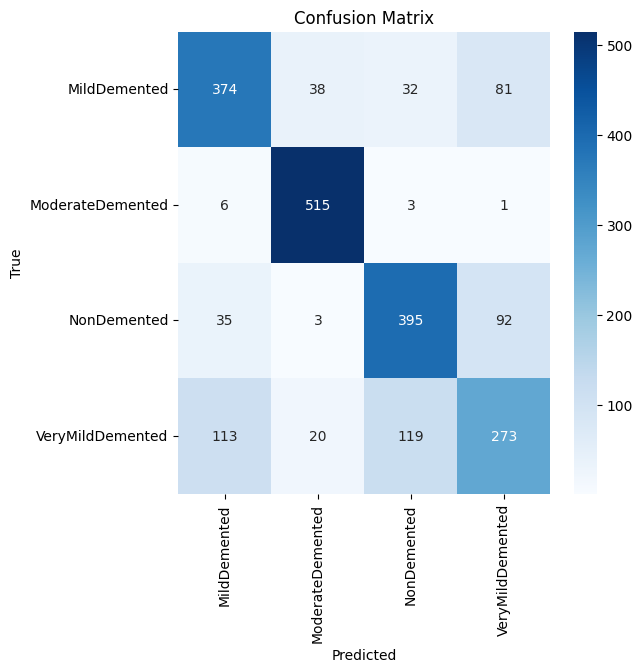

In [12]:
# Confusion matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

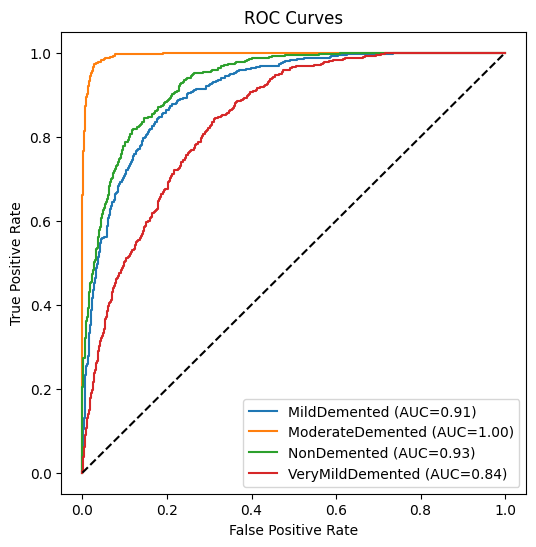

In [13]:
# ROC and AUC

from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=list(range(len(class_labels))))
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(6,6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

In [14]:
# Log Loss
logloss_value = log_loss(y_true_bin, y_pred_prob)
print(f"\nLog Loss: {logloss_value:.4f}")


Log Loss: 0.6105


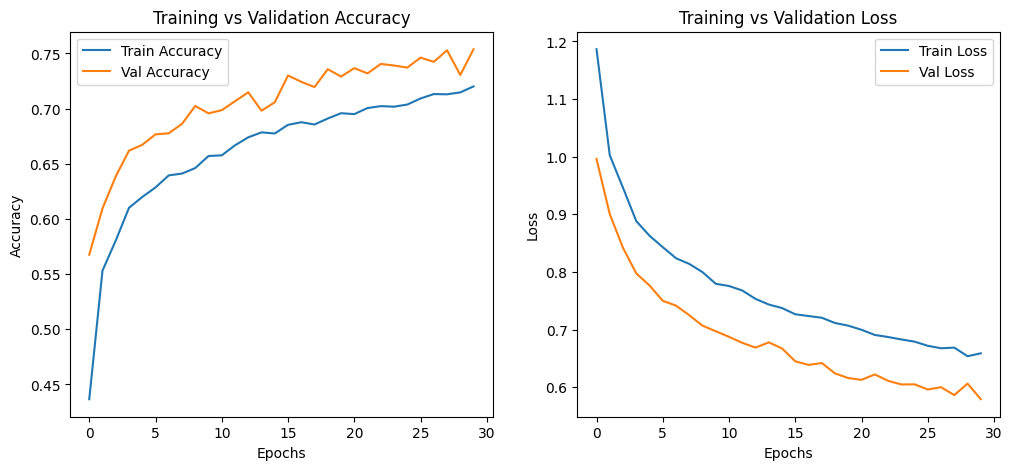

In [15]:
# STEP 7: TRAINING VS VALIDATION PLOTS
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

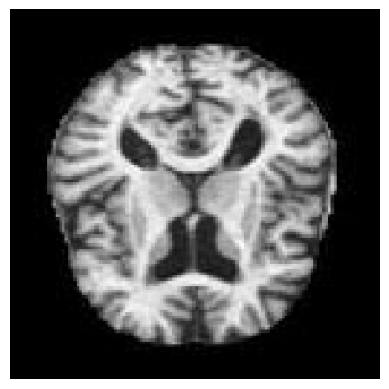

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted class: MildDemented


In [36]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# Replace this with your image path (from your dataset)
img_path = '/content/drive/MyDrive/split_ADNI/test/MildDemented/15 (28).jpg'

# STEP 1: Load and preprocess the image
img = image.load_img(img_path, target_size=(299,299))  # Xception input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)          # Add batch dimension
img_array /= 255.0                                     # Rescale

# STEP 2: Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# STEP 3: Predict with the trained model
pred_prob = model.predict(img_array)
pred_class_index = np.argmax(pred_prob, axis=1)[0]

# STEP 4: Map index to class name
class_labels = list(train_gen.class_indices.keys())
pred_class_name = class_labels[pred_class_index]

print(f"Predicted class: {pred_class_name}")
